# Transfer Learning

Most of the time you won't want to train a whole convolutional network yourself. Modern ConvNets training on huge datasets like ImageNet take weeks on multiple GPUs. Instead, most people use a pretrained network either as a fixed feature extractor, or as an initial network to fine tune. In this notebook, you'll be using [VGGNet](https://arxiv.org/pdf/1409.1556.pdf) trained on the [ImageNet dataset](http://www.image-net.org/) as a feature extractor. Below is a diagram of the VGGNet architecture.

<img src="assets/cnnarchitecture.jpg" width=700px>

VGGNet is great because it's simple and has great performance, coming in second in the ImageNet competition. The idea here is that we keep all the convolutional layers, but replace the final fully connected layers with our own classifier. This way we can use VGGNet as a feature extractor for our images then easily train a simple classifier on top of that. What we'll do is take the first fully connected layer with 4096 units, including thresholding with ReLUs. We can use those values as a code for each image, then build a classifier on top of those codes.

You can read more about transfer learning from [the CS231n course notes](http://cs231n.github.io/transfer-learning/#tf).

## Pretrained VGGNet

We'll be using a pretrained network from https://github.com/machrisaa/tensorflow-vgg. Make sure to clone this repository to the directory you're working from. You'll also want to rename it so it has an underscore instead of a dash.

```
git clone https://github.com/machrisaa/tensorflow-vgg.git tensorflow_vgg
```

This is a really nice implementation of VGGNet, quite easy to work with. The network has already been trained and the parameters are available from this link. _You'll need to clone the repo into the folder containing this notebook._ Then download the parameter file using the next cell.

In [1]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm

vgg_dir = 'tensorflow_vgg/'
# Make sure vgg exists
if not isdir(vgg_dir):
    raise Exception("VGG directory doesn't exist!")

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(vgg_dir + "vgg16.npy"):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='VGG16 Parameters') as pbar:
        urlretrieve(
            'https://s3.amazonaws.com/content.udacity-data.com/nd101/vgg16.npy',
            vgg_dir + 'vgg16.npy',
            pbar.hook)
else:
    print("Parameter file already exists!")

Parameter file already exists!


## Flower power

Here we'll be using VGGNet to classify images of flowers. To get the flower dataset, run the cell below. This dataset comes from the [TensorFlow inception tutorial](https://www.tensorflow.org/tutorials/image_retraining).

In [2]:
import tarfile

dataset_folder_path = 'flower_photos'

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile('flower_photos.tar.gz'):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='Flowers Dataset') as pbar:
        urlretrieve(
            'http://download.tensorflow.org/example_images/flower_photos.tgz',
            'flower_photos.tar.gz',
            pbar.hook)

if not isdir(dataset_folder_path):
    with tarfile.open('flower_photos.tar.gz') as tar:
        tar.extractall()
        tar.close()

## ConvNet Codes

Below, we'll run through all the images in our dataset and get codes for each of them. That is, we'll run the images through the VGGNet convolutional layers and record the values of the first fully connected layer. We can then write these to a file for later when we build our own classifier.

Here we're using the `vgg16` module from `tensorflow_vgg`. The network takes images of size $224 \times 224 \times 3$ as input. Then it has 5 sets of convolutional layers. The network implemented here has this structure (copied from [the source code](https://github.com/machrisaa/tensorflow-vgg/blob/master/vgg16.py)):

```
self.conv1_1 = self.conv_layer(bgr, "conv1_1")
self.conv1_2 = self.conv_layer(self.conv1_1, "conv1_2")
self.pool1 = self.max_pool(self.conv1_2, 'pool1')

self.conv2_1 = self.conv_layer(self.pool1, "conv2_1")
self.conv2_2 = self.conv_layer(self.conv2_1, "conv2_2")
self.pool2 = self.max_pool(self.conv2_2, 'pool2')

self.conv3_1 = self.conv_layer(self.pool2, "conv3_1")
self.conv3_2 = self.conv_layer(self.conv3_1, "conv3_2")
self.conv3_3 = self.conv_layer(self.conv3_2, "conv3_3")
self.pool3 = self.max_pool(self.conv3_3, 'pool3')

self.conv4_1 = self.conv_layer(self.pool3, "conv4_1")
self.conv4_2 = self.conv_layer(self.conv4_1, "conv4_2")
self.conv4_3 = self.conv_layer(self.conv4_2, "conv4_3")
self.pool4 = self.max_pool(self.conv4_3, 'pool4')

self.conv5_1 = self.conv_layer(self.pool4, "conv5_1")
self.conv5_2 = self.conv_layer(self.conv5_1, "conv5_2")
self.conv5_3 = self.conv_layer(self.conv5_2, "conv5_3")
self.pool5 = self.max_pool(self.conv5_3, 'pool5')

self.fc6 = self.fc_layer(self.pool5, "fc6")
self.relu6 = tf.nn.relu(self.fc6)
```

So what we want are the values of the first fully connected layer, after being ReLUd (`self.relu6`).

In [3]:
import os

import numpy as np
import tensorflow as tf

from tensorflow_vgg import vgg16
from tensorflow_vgg import utils

In [4]:
data_dir = 'flower_photos/'
contents = os.listdir(data_dir)
classes = [each for each in contents if os.path.isdir(data_dir + each)]

Below I'm running images through the VGG network in batches.

In [5]:
# Set the batch size higher if you can fit in in your GPU memory
batch_size = 100
codes_list = []
labels = []
batch = []

codes = None
vgg = vgg16.Vgg16()
input_ = tf.placeholder(tf.float32, [None, 224, 224, 3])
with tf.name_scope("content_vgg"):
    vgg.build(input_)
        

with tf.Session() as sess:
    for each in classes:
        print("Starting {} images".format(each))
        class_path = data_dir + each
        files = os.listdir(class_path)
        for ii, file in enumerate(files, 1):
            # Add images to the current batch
            # utils.load_image crops the input images for us, from the center
            img = utils.load_image(os.path.join(class_path, file))
            batch.append(img.reshape((1, 224, 224, 3)))
            labels.append(each)
            
            # Running the batch through the network to get the codes
            if ii % batch_size == 0 or ii == len(files):
                
                # Image batch to pass to VGG network
                images = np.concatenate(batch)
                
                feed_dict = {input_: images}
                codes_batch =  sess.run(vgg.relu6, feed_dict=feed_dict)
                
                # Here I'm building an array of the codes
                if codes is None:
                    codes = codes_batch
                else:
                    codes = np.concatenate((codes, codes_batch))
                
                # Reset to start building the next batch
                batch = []
                print('{} images processed'.format(ii))

/home/adrsta/Github/deep-learning/08_transfer-learning/tensorflow_vgg/vgg16.npy
npy file loaded
build model started
build model finished: 0s
Starting sunflowers images
100 images processed
200 images processed
300 images processed
400 images processed
500 images processed
600 images processed
699 images processed
Starting dandelion images
100 images processed
200 images processed
300 images processed
400 images processed
500 images processed
600 images processed
700 images processed
800 images processed
898 images processed
Starting tulips images
100 images processed
200 images processed
300 images processed
400 images processed
500 images processed
600 images processed
700 images processed
799 images processed
Starting roses images
100 images processed
200 images processed
300 images processed
400 images processed
500 images processed
600 images processed
641 images processed
Starting daisy images
100 images processed
200 images processed
300 images processed
400 images processed
500 

In [6]:
# write codes to file
with open('codes', 'w') as f:
    codes.tofile(f)
    
# write labels to file
import csv
with open('labels', 'w') as f:
    writer = csv.writer(f, delimiter='\n')
    writer.writerow(labels)

## Building the Classifier

Now that we have codes for all the images, we can build a simple classifier on top of them. The codes behave just like normal input into a simple neural network. Below I'm going to have you do most of the work.

In [7]:
# read codes and labels from file
import csv

with open('labels') as f:
    reader = csv.reader(f, delimiter='\n')
    labels = np.array([each for each in reader if len(each) > 0]).squeeze()
with open('codes') as f:
    codes = np.fromfile(f, dtype=np.float32)
    codes = codes.reshape((len(labels), -1))

### Data prep

As usual, now we need to one-hot encode our labels and create validation/test sets. First up, creating our labels!

From scikit-learn, use [LabelBinarizer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelBinarizer.html) to create one-hot encoded vectors from the labels. 

In [8]:
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
lb.fit(labels)
labels_vecs = lb.transform(labels)
labels_vecs

array([[0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       ..., 
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0]])

Now you'll want to create your training, validation, and test sets. An important thing to note here is that our labels and data aren't randomized yet. We'll want to shuffle our data so the validation and test sets contain data from all classes. Otherwise, you could end up with testing sets that are all one class. Typically, you'll also want to make sure that each smaller set has the same the distribution of classes as it is for the whole data set. The easiest way to accomplish both these goals is to use [StratifiedShuffleSplit](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html) from scikit-learn.

You can create the splitter like so:
```
ss = StratifiedShuffleSplit(n_splits=1, test_size=0.2)
```
Then split the data with 
```
splitter = ss.split(x, y)
```

`ss.split` returns a generator of indices. You can pass the indices into the arrays to get the split sets. The fact that it's a generator means you either need to iterate over it, or use `next(splitter)` to get the indices.

In [9]:
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
for train_index, test_index in sss.split(codes, labels_vecs):
    train_x, rest_x = codes[train_index], codes[test_index]
    train_y, rest_y = labels_vecs[train_index], labels_vecs[test_index]

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=0)
for train_index, test_index in sss.split(rest_x, rest_y):
    val_x, test_x = rest_x[train_index], rest_x[test_index]
    val_y, test_y = rest_y[train_index], rest_y[test_index]

In [10]:
print("Train shapes (x, y):", train_x.shape, train_y.shape)
print("Validation shapes (x, y):", val_x.shape, val_y.shape)
print("Test shapes (x, y):", test_x.shape, test_y.shape)

Train shapes (x, y): (2936, 4096) (2936, 5)
Validation shapes (x, y): (367, 4096) (367, 5)
Test shapes (x, y): (367, 4096) (367, 5)


### Classifier layers

Once you have the convolutional codes, you just need to build a classfier from some fully connected layers. You use the codes as the inputs and the image labels as targets. Otherwise the classifier is a typical neural network.

> **Exercise:** With the codes and labels loaded, build the classifier. Consider the codes as your inputs, each of them are 4096D vectors. You'll want to use a hidden layer and an output layer as your classifier. Remember that the output layer needs to have one unit for each class and a softmax activation function. Use the cross entropy to calculate the cost.

In [11]:
from tensorflow import layers

In [12]:
inputs_ = tf.placeholder(tf.float32, shape=[None, codes.shape[1]])
labels_ = tf.placeholder(tf.int64, shape=[None, labels_vecs.shape[1]])

fc = tf.layers.dense(inputs_, 2000, activation=tf.nn.relu)
logits = tf.layers.dense(fc, labels_vecs.shape[1], activation=None)

cost = tf.reduce_sum(tf.nn.softmax_cross_entropy_with_logits(labels=labels_,
                                                             logits=logits))

optimizer = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(cost)

# Operations for validation/test accuracy
predicted = tf.nn.softmax(logits)
correct_pred = tf.equal(tf.argmax(predicted, 1), tf.argmax(labels_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

### Batches!

Here is just a simple way to do batches. I've written it so that it includes all the data. Sometimes you'll throw out some data at the end to make sure you have full batches. Here I just extend the last batch to include the remaining data.

In [13]:
def get_batches(x, y, n_batches=10):
    """ Return a generator that yields batches from arrays x and y. """
    batch_size = len(x)//n_batches
    
    for ii in range(0, n_batches*batch_size, batch_size):
        # If we're not on the last batch, grab data with size batch_size
        if ii != (n_batches-1)*batch_size:
            X, Y = x[ii: ii+batch_size], y[ii: ii+batch_size] 
        # On the last batch, grab the rest of the data
        else:
            X, Y = x[ii:], y[ii:]
        # I love generators
        yield X, Y

### Training

Here, we'll train the network.


In [14]:
epochs = 10
batches = 100
saver = tf.train.Saver()
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for e in range(epochs):
        b = 0
        for x, y in get_batches(train_x, train_y, batches):
            feed = {inputs_: x,
                    labels_: y}
            batch_cost, _ = sess.run([cost, optimizer], feed_dict=feed)
            print("Epoch: {}/{} ".format(e+1, epochs),
                  "Batch: {}/{} ".format(b+1, batches),
                  "Training loss: {:.4f}".format(batch_cost))
            b += 1      
    saver.save(sess, "checkpoints/flowers.ckpt")

Epoch: 1/10  Batch: 1/100  Training loss: 258.3085
Epoch: 1/10  Batch: 2/100  Training loss: 213.2260
Epoch: 1/10  Batch: 3/100  Training loss: 120.0142
Epoch: 1/10  Batch: 4/100  Training loss: 99.7718
Epoch: 1/10  Batch: 5/100  Training loss: 54.0191
Epoch: 1/10  Batch: 6/100  Training loss: 49.9562
Epoch: 1/10  Batch: 7/100  Training loss: 45.4586
Epoch: 1/10  Batch: 8/100  Training loss: 50.2755
Epoch: 1/10  Batch: 9/100  Training loss: 16.9481
Epoch: 1/10  Batch: 10/100  Training loss: 34.4742
Epoch: 1/10  Batch: 11/100  Training loss: 46.4253
Epoch: 1/10  Batch: 12/100  Training loss: 83.4526
Epoch: 1/10  Batch: 13/100  Training loss: 20.3686
Epoch: 1/10  Batch: 14/100  Training loss: 19.7525
Epoch: 1/10  Batch: 15/100  Training loss: 22.1988
Epoch: 1/10  Batch: 16/100  Training loss: 58.0417
Epoch: 1/10  Batch: 17/100  Training loss: 60.0108
Epoch: 1/10  Batch: 18/100  Training loss: 37.6135
Epoch: 1/10  Batch: 19/100  Training loss: 32.6551
Epoch: 1/10  Batch: 20/100  Training 

Epoch: 3/10  Batch: 5/100  Training loss: 1.1870
Epoch: 3/10  Batch: 6/100  Training loss: 1.2752
Epoch: 3/10  Batch: 7/100  Training loss: 0.1427
Epoch: 3/10  Batch: 8/100  Training loss: 3.9666
Epoch: 3/10  Batch: 9/100  Training loss: 0.4113
Epoch: 3/10  Batch: 10/100  Training loss: 0.1738
Epoch: 3/10  Batch: 11/100  Training loss: 0.5143
Epoch: 3/10  Batch: 12/100  Training loss: 0.0687
Epoch: 3/10  Batch: 13/100  Training loss: 2.0308
Epoch: 3/10  Batch: 14/100  Training loss: 3.1288
Epoch: 3/10  Batch: 15/100  Training loss: 0.4315
Epoch: 3/10  Batch: 16/100  Training loss: 1.3767
Epoch: 3/10  Batch: 17/100  Training loss: 3.2803
Epoch: 3/10  Batch: 18/100  Training loss: 0.0193
Epoch: 3/10  Batch: 19/100  Training loss: 0.1545
Epoch: 3/10  Batch: 20/100  Training loss: 0.2449
Epoch: 3/10  Batch: 21/100  Training loss: 3.1252
Epoch: 3/10  Batch: 22/100  Training loss: 7.7259
Epoch: 3/10  Batch: 23/100  Training loss: 0.0424
Epoch: 3/10  Batch: 24/100  Training loss: 0.2353
Epoch

Epoch: 5/10  Batch: 16/100  Training loss: 0.0008
Epoch: 5/10  Batch: 17/100  Training loss: 1.0116
Epoch: 5/10  Batch: 18/100  Training loss: 0.7292
Epoch: 5/10  Batch: 19/100  Training loss: 0.2628
Epoch: 5/10  Batch: 20/100  Training loss: 0.0062
Epoch: 5/10  Batch: 21/100  Training loss: 0.0111
Epoch: 5/10  Batch: 22/100  Training loss: 0.0112
Epoch: 5/10  Batch: 23/100  Training loss: 0.0023
Epoch: 5/10  Batch: 24/100  Training loss: 0.0883
Epoch: 5/10  Batch: 25/100  Training loss: 0.0013
Epoch: 5/10  Batch: 26/100  Training loss: 0.0281
Epoch: 5/10  Batch: 27/100  Training loss: 0.0021
Epoch: 5/10  Batch: 28/100  Training loss: 0.0065
Epoch: 5/10  Batch: 29/100  Training loss: 0.0174
Epoch: 5/10  Batch: 30/100  Training loss: 0.0081
Epoch: 5/10  Batch: 31/100  Training loss: 0.4352
Epoch: 5/10  Batch: 32/100  Training loss: 5.8039
Epoch: 5/10  Batch: 33/100  Training loss: 0.0198
Epoch: 5/10  Batch: 34/100  Training loss: 0.0106
Epoch: 5/10  Batch: 35/100  Training loss: 0.0873


Epoch: 7/10  Batch: 30/100  Training loss: 0.0031
Epoch: 7/10  Batch: 31/100  Training loss: 0.0261
Epoch: 7/10  Batch: 32/100  Training loss: 0.1148
Epoch: 7/10  Batch: 33/100  Training loss: 0.0091
Epoch: 7/10  Batch: 34/100  Training loss: 0.0123
Epoch: 7/10  Batch: 35/100  Training loss: 0.0400
Epoch: 7/10  Batch: 36/100  Training loss: 0.0002
Epoch: 7/10  Batch: 37/100  Training loss: 0.0055
Epoch: 7/10  Batch: 38/100  Training loss: 0.0004
Epoch: 7/10  Batch: 39/100  Training loss: 0.0046
Epoch: 7/10  Batch: 40/100  Training loss: 0.0447
Epoch: 7/10  Batch: 41/100  Training loss: 0.0101
Epoch: 7/10  Batch: 42/100  Training loss: 0.0050
Epoch: 7/10  Batch: 43/100  Training loss: 0.0042
Epoch: 7/10  Batch: 44/100  Training loss: 0.0170
Epoch: 7/10  Batch: 45/100  Training loss: 0.0077
Epoch: 7/10  Batch: 46/100  Training loss: 0.0006
Epoch: 7/10  Batch: 47/100  Training loss: 0.0026
Epoch: 7/10  Batch: 48/100  Training loss: 0.0060
Epoch: 7/10  Batch: 49/100  Training loss: 0.0130


Epoch: 9/10  Batch: 40/100  Training loss: 0.0074
Epoch: 9/10  Batch: 41/100  Training loss: 0.0068
Epoch: 9/10  Batch: 42/100  Training loss: 0.0034
Epoch: 9/10  Batch: 43/100  Training loss: 0.0024
Epoch: 9/10  Batch: 44/100  Training loss: 0.0097
Epoch: 9/10  Batch: 45/100  Training loss: 0.0052
Epoch: 9/10  Batch: 46/100  Training loss: 0.0006
Epoch: 9/10  Batch: 47/100  Training loss: 0.0020
Epoch: 9/10  Batch: 48/100  Training loss: 0.0044
Epoch: 9/10  Batch: 49/100  Training loss: 0.0102
Epoch: 9/10  Batch: 50/100  Training loss: 0.0021
Epoch: 9/10  Batch: 51/100  Training loss: 0.0003
Epoch: 9/10  Batch: 52/100  Training loss: 0.0041
Epoch: 9/10  Batch: 53/100  Training loss: 0.0030
Epoch: 9/10  Batch: 54/100  Training loss: 0.0039
Epoch: 9/10  Batch: 55/100  Training loss: 0.0065
Epoch: 9/10  Batch: 56/100  Training loss: 0.0044
Epoch: 9/10  Batch: 57/100  Training loss: 0.0021
Epoch: 9/10  Batch: 58/100  Training loss: 0.0035
Epoch: 9/10  Batch: 59/100  Training loss: 0.0001


### Testing

Below you see the test accuracy. You can also see the predictions returned for images.

In [15]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    feed = {inputs_: test_x,
            labels_: test_y}
    test_acc = sess.run(accuracy, feed_dict=feed)
    print("Test accuracy: {:.4f}".format(test_acc))

INFO:tensorflow:Restoring parameters from checkpoints/flowers.ckpt
Test accuracy: 0.9455


In [16]:
%matplotlib inline

import matplotlib.pyplot as plt
from scipy.ndimage import imread

Below, feel free to choose images and see how the trained classifier predicts the flowers in them.

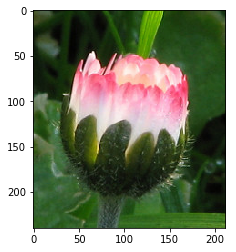

In [17]:
test_img_path = 'flower_photos/daisy/144603918_b9de002f60_m.jpg'
test_img = imread(test_img_path)
plt.imshow(test_img)

In [18]:
# Run this cell if you don't have a vgg graph built
if 'vgg' in globals():
    print('"vgg" object already exists.  Will not create again.')
else:
    #create vgg
    with tf.Session() as sess:
        input_ = tf.placeholder(tf.float32, [None, 224, 224, 3])
        vgg = vgg16.Vgg16()
        vgg.build(input_)

"vgg" object already exists.  Will not create again.


In [19]:
batch = []
with tf.Session() as sess:     
    img = utils.load_image(test_img_path)
    batch.append(img.reshape((1, 224, 224, 3)))
    images = np.concatenate(batch)

    feed_dict = {input_: images}
    code = sess.run(vgg.relu6, feed_dict=feed_dict)
        
saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    feed = {inputs_: code}
    prediction = sess.run(predicted, feed_dict=feed).squeeze()

INFO:tensorflow:Restoring parameters from checkpoints/flowers.ckpt


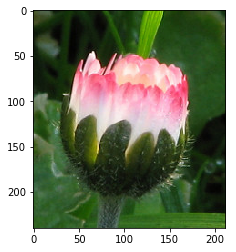

In [20]:
plt.imshow(test_img)

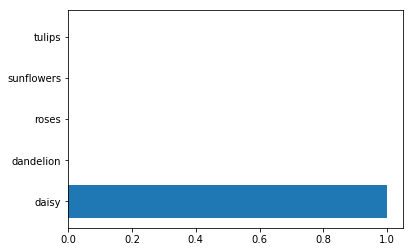

In [21]:
plt.barh(np.arange(5), prediction)
_ = plt.yticks(np.arange(5), lb.classes_)

## Find photos that were mistakenly calassified

In [25]:
data_dir = 'flower_photos/'
contents = os.listdir(data_dir)
classes = [each for each in contents if os.path.isdir(data_dir + each)]        

with tf.Session() as sess:     
    saver = tf.train.Saver()
    with tf.Session() as sess2:
        saver.restore(sess2, tf.train.latest_checkpoint('checkpoints'))

        for each in classes:
            print("Starting {} images".format(each))
            class_path = data_dir + each
            files = os.listdir(class_path)
            
            for file in files:
                batch = []
                labels = []

                img = utils.load_image(os.path.join(class_path, file))
                batch.append(img.reshape((1, 224, 224, 3)))
                labels.append(lb.transform([each])[0])
                images = np.concatenate(batch)

                feed_dict = {input_: images}
                code = sess.run(vgg.relu6, feed_dict=feed_dict)

                feed = {inputs_: code, labels_: labels}
                correct, prediction = sess2.run([correct_pred, predicted], feed_dict=feed)
                
                if not correct[0]:
                    #test_img = imread(os.path.join(class_path, file))
                    #plt.imshow(test_img)
                    #plt.barh(np.arange(5), prediction)
                    #_ = plt.yticks(np.arange(5), lb.classes_)
                    print(os.path.join(class_path, file))


INFO:tensorflow:Restoring parameters from checkpoints/flowers.ckpt
Starting sunflowers images
flower_photos/sunflowers/16832961488_5f7e70eb5e_n.jpg
flower_photos/sunflowers/8543642705_b841b0e5f6.jpg
flower_photos/sunflowers/8202034834_ee0ee91e04_n.jpg
flower_photos/sunflowers/2883115621_4837267ea1_m.jpg
flower_photos/sunflowers/7176729016_d73ff2211e.jpg
flower_photos/sunflowers/22478719251_276cb094f9_n.jpg
flower_photos/sunflowers/15207507116_8b7f894508_m.jpg
flower_photos/sunflowers/4872284527_ff52128b97.jpg
flower_photos/sunflowers/9460336948_6ae968be93.jpg
flower_photos/sunflowers/9231555352_d2dd8f8e68_m.jpg
flower_photos/sunflowers/265422922_bbbde781d2_m.jpg
flower_photos/sunflowers/2729206569_9dd2b5a3ed.jpg
flower_photos/sunflowers/3734999477_7f454081aa_n.jpg
flower_photos/sunflowers/10386522775_4f8c616999_m.jpg
flower_photos/sunflowers/19710925313_31682fa22b_m.jpg
flower_photos/sunflowers/8928614683_6c168edcfc.jpg
flower_photos/sunflowers/6239758929_50e5e5a476_m.jpg
flower_photos

flower_photos/daisy/20182559506_40a112f762.jpg
flower_photos/daisy/3611577717_f3a7a8c416_n.jpg
flower_photos/daisy/14088053307_1a13a0bf91_n.jpg
flower_photos/daisy/134372449_0f7166d96c_n.jpg
